ValueError: Axis limits cannot be NaN or Inf

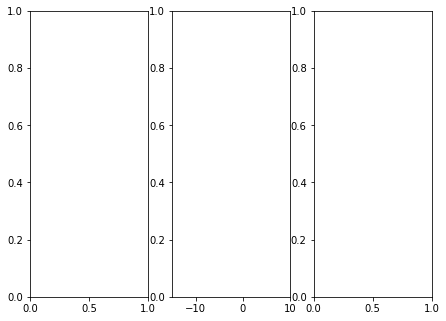

In [7]:
# -*- coding: utf-8 -*-
"""
Created on Mon Oct 24 13:53:53 2016

@author: jhusson
"""

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import pandas as pd
cnames=colors.cnames

#MAGIC! 
def getKey(item):
    return item[1]
    
#MAKE A STRATIGRAPHIC LITHOLOGY KEY
def stratkey(ax, strat_style):
    
    boxes=[]

    for k in strat_style.keys():
        boxes.append(strat_style[k])
    
    boxes=list(set(boxes))
    boxes=sorted(boxes,key=getKey)
    
    h=1/float(len(boxes))
    stack=0
    for b in boxes:
        rect = patches.Rectangle((0, stack),  b[1], h,
          facecolor=b[0],edgecolor="none")
        stack=stack+h
        ax.add_patch(rect)
        label=','.join([k for k in strat_style if strat_style[k]==b])
        ax.text(1,stack-h/2,label,transform=ax.transAxes,horizontalalignment='right',verticalalignment='center')
    
    ax.text(0.5,1.05,'lithostratigraphic key',transform=ax.transAxes,fontweight='bold',horizontalalignment='center')
    ax.axis('off')
    
##MAKE SIMPLE STRATIGRAPHIC COLUMNS 
def pystrat(ax,strat,style,jitter,draw_trace):
    stack=0
    stack_max=sum(strat['THICKNESS'])
    
    ax.axis([0, 1, 0,stack_max])
    
    trace=[]
    for i,s in strat.iterrows():
        
        if s['GRAIN_SIZE'] in style.keys():
            w=style[s['GRAIN_SIZE']][1]
            c=style[s['GRAIN_SIZE']][0]
        else:
            w=1
            c='black'
            

        jitter_y=[]
        jitter_x=[]

        
        if w!=0:
            jitter_y=np.arange(stack+jitter['y']/2,stack+s['THICKNESS'],jitter['y'])
            jitter_w=np.linspace(w-jitter['spread'],w+jitter['spread'],len(jitter_y)+2)
            jitter_x=np.random.uniform(-1*jitter['x'],jitter['x'],len(jitter_y))+jitter_w[1:-1]
            
        if len(jitter_y)==0:
            w_box=[w,w]
        else:
            w_box=[w-jitter['spread'],w+jitter['spread']]
            
        xy=np.array([(0,stack),
                     (w_box[0],stack)]
                     +list(zip(jitter_x,jitter_y))
                     +[(w_box[1],stack+s['THICKNESS']),
                     (0,stack+s['THICKNESS'])])
    
        rect = Polygon(xy,closed=True,
                          facecolor=c,edgecolor="none")
        
        ax.add_patch(rect)
        
        trace.extend([(w_box[0],stack)]
                     +list(zip(jitter_x,jitter_y))
                     +[(w_box[1],stack+s['THICKNESS'])])
    
        stack=stack+s['THICKNESS']
        
    ax.plot([0,0],[0,stack_max],lw=1,color='k')
    ax.plot([0,1],[0,0],lw=1,color='k')
    
    if draw_trace['on']:
        ax.plot([t[0] for t in trace],[t[1] for t in trace],'k-',lw=draw_trace['lw'])
    
    ax.axis('off')
    


#%% STRATIGRAPHIC PLOT OF DATA
fig3=plt.figure(3,figsize=(7.2,5.2625))
fig3.clf()
fig3.patch.set_facecolor('white')
ax3a = fig3.add_subplot(131)
ax3b = fig3.add_subplot(132)
ax3c = fig3.add_subplot(133)

#load in the stratigraphic and isotopic datafile
strat=pd.read_csv('Mt_Fitzwilliam_data.csv')

#STYLE DICTIONARY
#every unique lithofacies (grainsize) needs its own entry
#entry is tuple of (color, width)
strat_style={'dolostone': (cnames['darkorchid'], 0.7),
       'silisiclastics': (cnames['lightsalmon'], 0.25),
     'cover': (cnames['white'], 0),
     'limestone': (cnames['lightsalmon'], 0.7),
     'wackestone': (cnames['olivedrab'], 0.6),
     'grainstone': (cnames['turquoise'], 0.6)}

#MAKE A STRAT PLOT
#'jitter' parameter gives the right-side of strat boxes a ragged look:
#       y - determines the spacing of ragged points
#       x - determines the amplitude of ragged points
#       spread - makes each bed "coarsening upwards" or "fining upwards" 
#'draw_trace' parameter:
#       on - if set to True, will outline the right-edge of the full strat column
#       lw - the width of line for this stratigraphic outline
#pystrat(ax3a,strat,strat_style,
        #jitter={'y':0.5, 'x': 0.025,'spread':0.05},
        #draw_trace={'on':True,'lw':0.125})

#SUBSET THE DATA TO JUST INCLUDE THE GEOCHEMISTRY
strat_geochem=strat[np.isnan(strat['d13C_carb'])==False]
strat_geochem=strat_geochem[np.isnan(strat_geochem['sample_height'])==False]

#DETERMINE LIMESTONE VS DOLOSTONE
#idx=[int(i-1) for i in strat_geochem['layer']]

#CONNOR! THIS IS WHERE I THINK THE LITHO MATTERS NEXT TO THE CHEMO

#is_ls=np.array([False if strat['LITHOLOGY'][i]=='dl' else True for i in idx])

#PLOT D13C - LIMESTONES
#ax3b.plot(strat_geochem['d13C_carb'][is_ls],strat_geochem['sample_height'][is_ls],
          #'o',markerfacecolor=cnames['mediumpurple'],
           # markeredgecolor="none",label='limestone')
            
#PLOT D13C - DOLOSTONES
#ax3b.plot(strat_geochem['d13C_carb'][is_ls==False],
          #strat_geochem['sample_height'][is_ls==False],'o',
           # markerfacecolor="none",label='dolostone',
            #markeredgecolor=cnames['mediumpurple'])


#PLOT FORMATS
ax3b.axis([-15, 10, 0,sum(strat['THICKNESS'])])
ax3b.set_ylabel('stratigraphic height (m)')
ax3b.set_xlabel('$\delta^{13}$C on carbonate')
ax3b.legend(loc=2,fontsize=12,numpoints=1)

#PLOT D18O - LIMESTONES
ax3c.plot(strat_geochem['d18O_carb'][is_ls],strat_geochem['sample_height'][is_ls],
          'o',markerfacecolor=cnames['mediumpurple'],
            markeredgecolor="none",label='limestone')
            
#PLOT D18O - DOLOSTONES
ax3c.plot(strat_geochem['d18O_carb'][is_ls==False],
          strat_geochem['sample_height'][is_ls==False],'o',
            markerfacecolor="none",label='dolostone',
            markeredgecolor=cnames['mediumpurple'])


#PLOT FORMATS
ax3c.axis([-16, -7, 0,sum(strat['THICKNESS'])])
ax3c.set_yticklabels([''])
ax3c.set_xlabel('$\delta^{18}$O on carbonate')

#%%
#MAKE A STRATIGRAPHIC KEY
fig4=plt.figure(4)
fig4.clf()
fig4.patch.set_facecolor('white')
stratkey(fig4.add_subplot(111), strat_style)
